<a href="https://colab.research.google.com/github/LUUTHIENXUAN/SwinMLP-implementation-in-Tensorflow/blob/main/Image_classification_with_SwinMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with SwinMLP

**Author:** [LUU THIEN XUAN](https://www.linkedin.com/in/thienxuanluu/)<br>
**Credit:** [Rishit Dagli](https://twitter.com/rishit_dagli)<br>
**Date created:** 2022/02/27<br>
**Last modified:** 2022/02/27<br>
**Description:** Image classification using Swin Transformers, a general-purpose backbone for computer vision.

https://github.com/microsoft/Swin-Transformer.

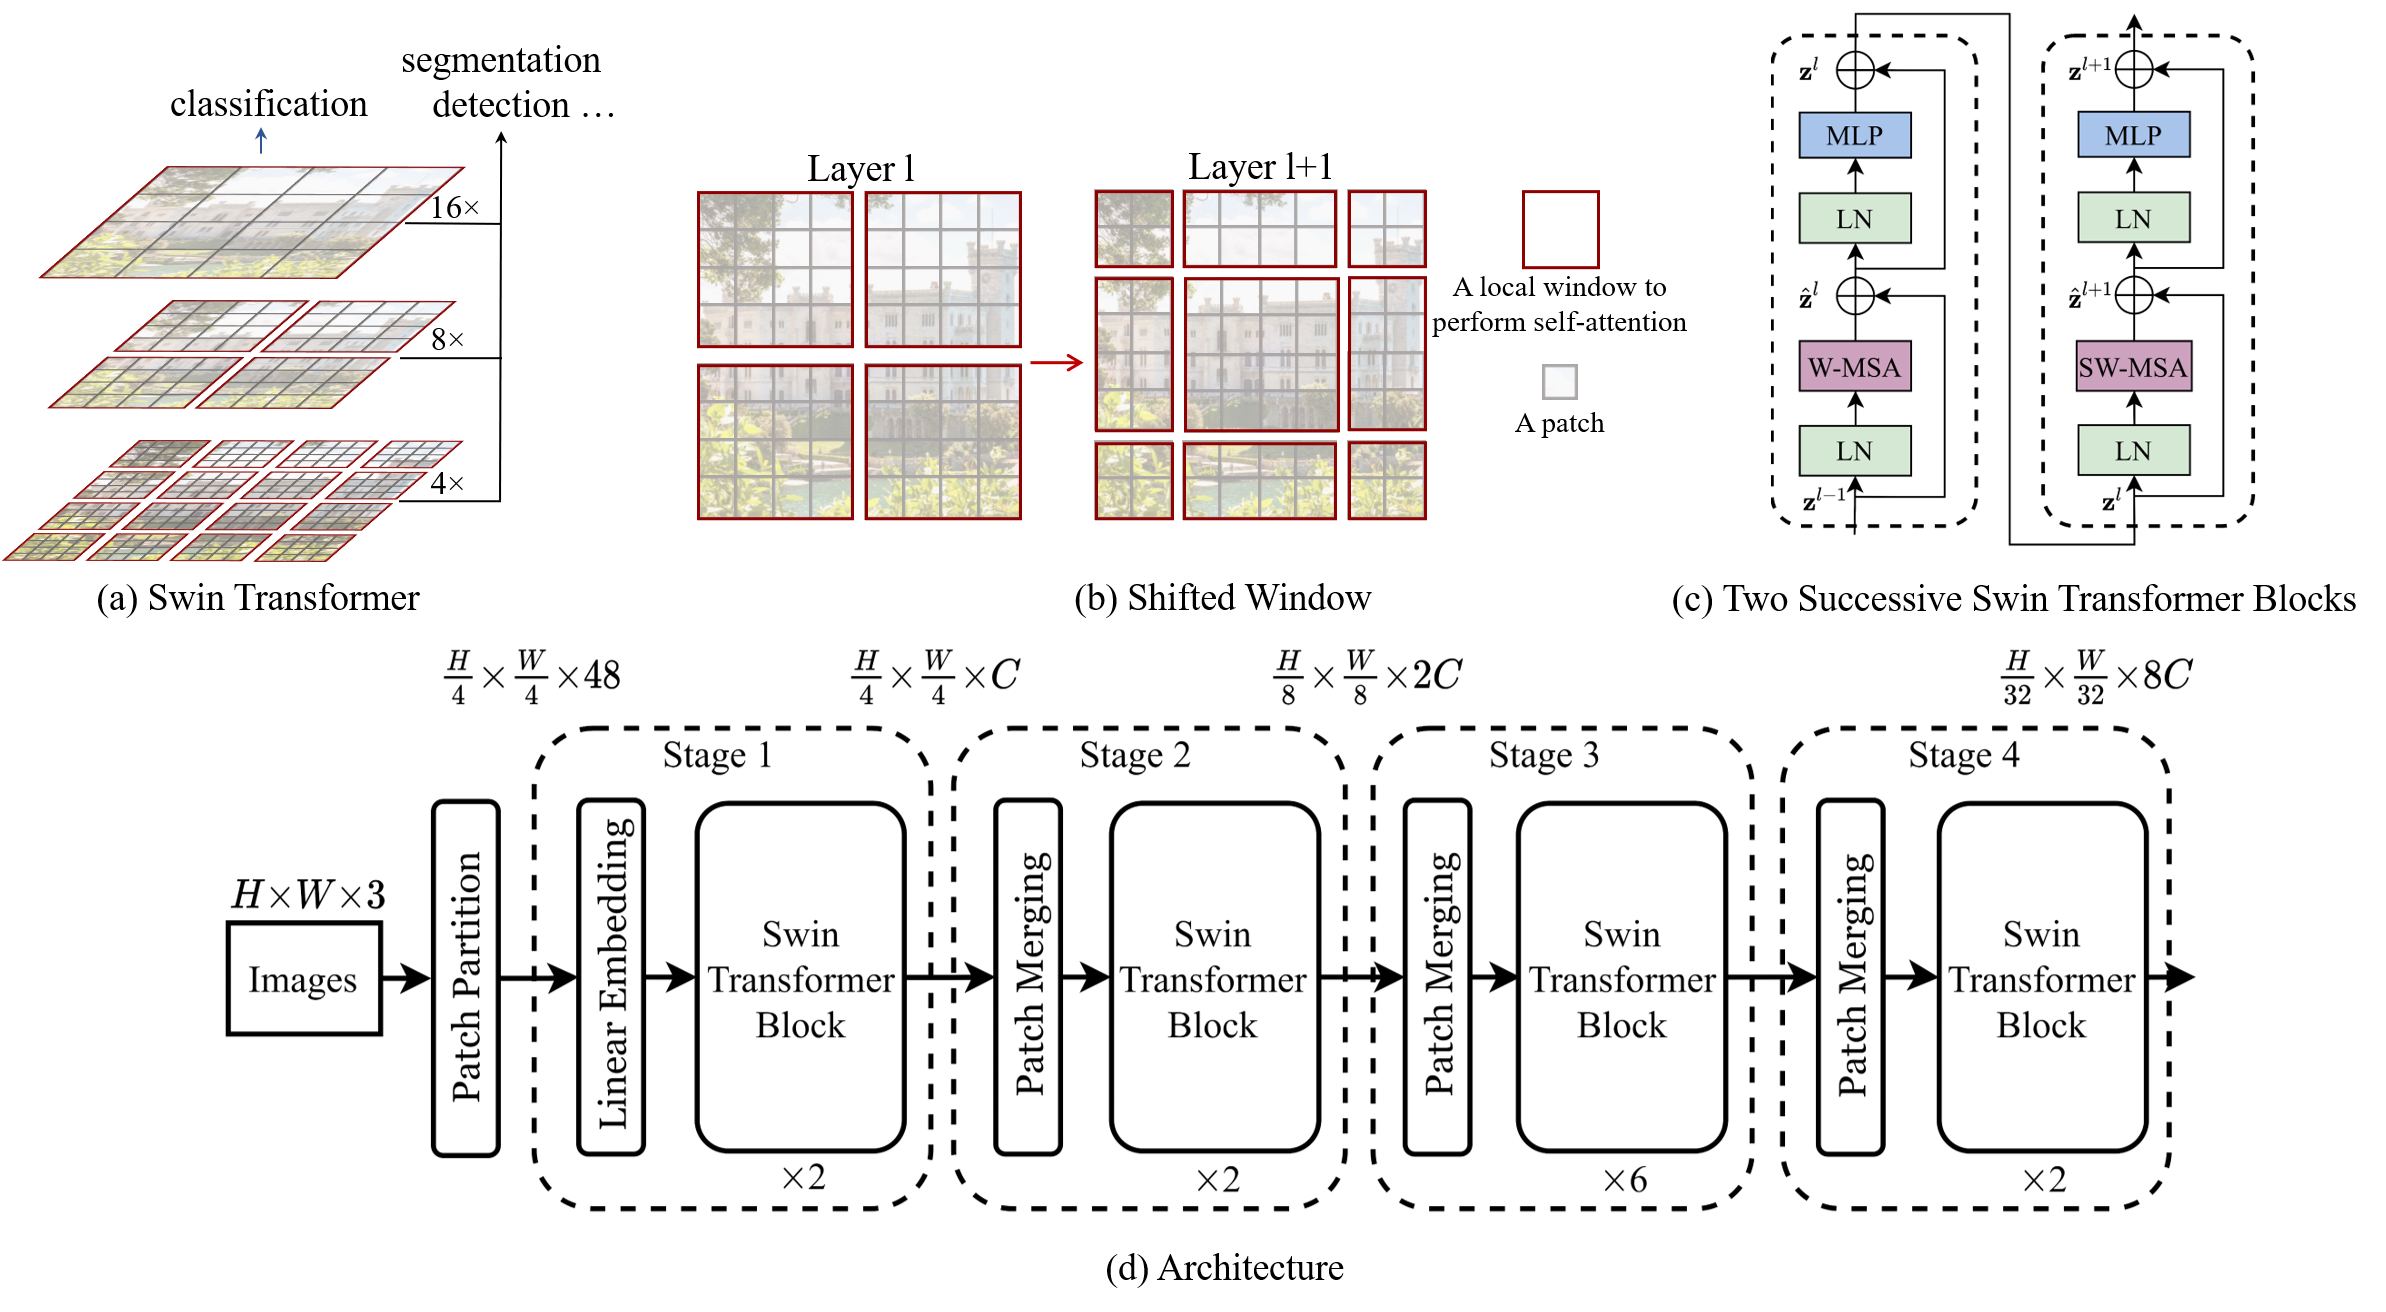

This example implements [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a general-purpose backbone
for computer vision. Swin Transformer is a hierarchical Transformer whose
representations are computed with _shifted windows_. The shifted window scheme
brings greater efficiency by limiting self-attention computation to
non-overlapping local windows while also allowing for cross-window connections.
This architecture has the flexibility to model information at various scales and has
a linear computational complexity with respect to image size.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Addons,
which can be installed using the following commands:

In [1]:
!pip install -U tensorflow-addons

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

We load the CIFAR-100 dataset through `tf.keras.datasets`,
normalize the images, and convert the integer labels to one-hot encoded vectors.

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


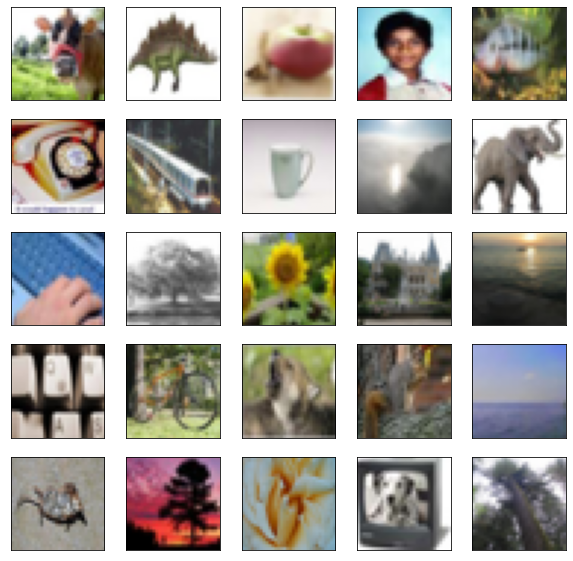

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to `(1, 1)`.
Below, we take inspiration from the original paper settings
for training on ImageNet-1K, keeping most of the original settings for this example.

In [4]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [5]:
class Mlp(layers.Layer):
  def __init__(self, out_features, hidden_features, dropout=0.):
    super(Mlp, self).__init__()
    self.net =  keras.Sequential([
                    layers.Dense(hidden_features, activation = tf.nn.gelu),
                    layers.Dropout(dropout),
                    layers.Dense(out_features),
                    layers.Dropout(dropout)
                    ])
  @tf.function(jit_compile=True)
  def call(self, x):
    return self.net(x)

In [6]:
@tf.function(jit_compile=True)
def window_partition(x, window_size):
  """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
  """
  B, H, W, C = tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2],tf.shape(x)[3] 
  x = tf.reshape(
        x, 
        shape=(B, H // window_size, window_size, W // window_size, window_size, C)
    )
  x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
  windows = tf.reshape(x, shape=(-1, window_size, window_size, C))
  return windows

@tf.function(jit_compile=True)
def window_reverse(windows, window_size, H, W):
  """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
  """
  B = int(tf.shape(windows)[0] / tf.cast((H * W / window_size / window_size),tf.int32))
  x = tf.reshape(
        windows,
        shape=(B, W // window_size, W // window_size, window_size, window_size,-1),
    )
  x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
  x = tf.reshape(x, shape=(B, H, W, -1))
  return x


class DropPath(layers.Layer):
  def __init__(self, drop_prob=None, **kwargs):
    super(DropPath, self).__init__(**kwargs)
    self.drop_prob = drop_prob
  
  @tf.function(jit_compile=True)
  def call(self, x):
    input_shape = tf.shape(x)
    batch_size = input_shape[0]
    rank = x.shape.rank
    shape = (batch_size,) + (1,) * (rank - 1)
    random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
    path_mask = tf.floor(random_tensor)
    output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
    return output

## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard multi-head
attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [7]:
import sys
class SwinMLP(layers.Layer):

  """ Swin MLP Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
  """
  def __init__(self,dim,input_resolution,num_heads,window_size=7,shift_size=0,
               num_mlp=1024,dropout_rate=0.0,**kwargs,):

    super(SwinMLP, self).__init__(**kwargs)

    self.dim = dim 
    self.input_resolution = input_resolution
    self.num_heads = num_heads
    self.window_size = window_size
    self.shift_size = shift_size
    self.num_mlp = num_mlp
    if min(self.input_resolution) < self.window_size:
      # if window size is larger than input resolution, we don't partition windows
      self.shift_size = 0
      self.window_size = min(self.input_resolution)
    assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

    self.padding = [self.window_size - self.shift_size, self.shift_size,
                    self.window_size - self.shift_size, self.shift_size]  # P_l,P_r,P_t,P_b

    self.norm1 = layers.LayerNormalization(epsilon=1e-5)
    # use group convolution to implement multi-head MLP
    self.spatial_mlp = layers.Conv1D(self.num_heads * self.window_size ** 2,
                                     kernel_size=1,
                                     groups=self.num_heads,
                                     data_format='channels_first'
                                     )
    
    self.drop_path = DropPath(dropout_rate)
    self.norm2 = layers.LayerNormalization(epsilon=1e-5)
    self.mlp = Mlp(dim, num_mlp, dropout_rate)

  @tf.function(jit_compile=True)
  def call(self, x):

    H, W = self.input_resolution
    _, L, C = x.shape
    assert L == H * W, "input feature has wrong size"

    x_skip = x
    x = self.norm1(x)
    x = tf.reshape(x, shape=(-1, H, W, C))

    # shift
    if self.shift_size > 0:
      P_l, P_r, P_t, P_b = self.padding
      shifted_x = tf.pad(x, [[0, 0],[P_t, P_b],[P_l, P_r],[0, 0]], 'CONSTANT', 0)
    else:
      shifted_x = x
    _, _H, _W, _ = shifted_x.shape

    # partition windows
    x_windows = window_partition(shifted_x, self.window_size) # nW*B, window_size, window_size, C
    x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, C)) # nW*B, window_size*window_size, C
    
    # Window/Shifted-Window Spatial MLP
    x_windows_heads = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, self.num_heads, C // self.num_heads))
    x_windows_heads = tf.transpose(x_windows_heads, perm=(0, 2, 1, 3))  # nW*B, nH, window_size*window_size, C//nH
    x_windows_heads = tf.reshape(x_windows_heads, (-1, self.num_heads * self.window_size * self.window_size,
                                                   C // self.num_heads))
    spatial_mlp_windows = self.spatial_mlp(x_windows_heads)  # nW*B, nH*window_size*window_size, C//nH
    spatial_mlp_windows = tf.reshape(spatial_mlp_windows,(-1, self.num_heads, self.window_size * self.window_size,
                                                          C // self.num_heads))
    spatial_mlp_windows = tf.transpose(spatial_mlp_windows, perm=(0, 2, 1, 3))
    spatial_mlp_windows = tf.reshape(spatial_mlp_windows,shape=(-1, self.window_size * self.window_size, C))
    
    # merge windows
    spatial_mlp_windows = tf.reshape(spatial_mlp_windows, shape= (-1, self.window_size, self.window_size, C))
    shifted_x = window_reverse(spatial_mlp_windows, self.window_size, _H, _W)  # B H' W' C
    
    # reverse shift
    if self.shift_size > 0:
      P_l, P_r, P_t, P_b = self.padding
      x = shifted_x[:, P_t:-P_b, P_l:-P_r, :]
    else:
      x = shifted_x
    x = tf.reshape(x, shape=(-1, H * W, C))
    
    # FFN
    x = x_skip + x
    x = x + self.drop_path(self.mlp(self.norm2(x)))
    
    return x

  def flops(self):
    flops = 0
    H, W = self.input_resolution
    # norm1
    flops += self.dim * H * W
    # W-MSA/SW-MSA
    nW = H * W / self.window_size / self.window_size
    flops += nW * self.attn.flops(self.window_size * self.window_size)
    # mlp
    flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
    # norm2
    flops += self.dim * H * W
    return 


## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [8]:
class PatchExtract(layers.Layer):
  def __init__(self, patch_size, **kwargs):
    super(PatchExtract, self).__init__(**kwargs)
    self.patch_size_x = patch_size[0]
    self.patch_size_y = patch_size[0]
  
  @tf.function(jit_compile=True)
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
  def __init__(self, num_patch, embed_dim, **kwargs):
    super(PatchEmbedding, self).__init__(**kwargs)
    self.num_patch = num_patch
    self.proj = layers.Dense(embed_dim)
    self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)
  
  @tf.function(jit_compile=True)
  def call(self, patch):
    pos = tf.range(start=0, limit=self.num_patch, delta=1)
    return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
  def __init__(self, num_patch, embed_dim):
    super(PatchMerging, self).__init__()
    self.num_patch = num_patch
    self.embed_dim = embed_dim
    self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)
  
  @tf.function(jit_compile=True)
  def call(self, x):
    height, width = self.num_patch
    _, _, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=(-1, height, width, C))
    x0 = x[:, 0::2, 0::2, :]
    x1 = x[:, 1::2, 0::2, :]
    x2 = x[:, 0::2, 1::2, :]
    x3 = x[:, 1::2, 1::2, :]
    x = tf.concat((x0, x1, x2, x3), axis=-1)
    x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
    return self.linear_trans(x)


### Build the model

We put together the Swin Transformer model.

In [ ]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinMLP(
    dim=embed_dim,
    input_resolution=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    dropout_rate=dropout_rate,
)(x)

x = SwinMLP(
    dim=embed_dim,
    input_resolution=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    dropout_rate=dropout_rate,
)(x)

x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

## Train on CIFAR-100

We train the model on CIFAR-100. Here, we only train the model
for 40 epochs to keep the training time short in this example.
In practice, you should train for 150 epochs to reach convergence.

In [11]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/40
352/352 [==============================] - 25s 47ms/step - loss: 4.1651 - accuracy: 0.0837 - top-5-accuracy: 0.2583 - val_loss: 3.9137 - val_accuracy: 0.1302 - val_top-5-accuracy: 0.3602
Epoch 2/40
352/352 [==============================] - 12s 33ms/step - loss: 3.7187 - accuracy: 0.1699 - top-5-accuracy: 0.4320 - val_loss: 3.6235 - val_accuracy: 0.1950 - val_top-5-accuracy: 0.4740
Epoch 3/40
352/352 [==============================] - 12s 33ms/step - loss: 3.4952 - accuracy: 0.2207 - top-5-accuracy: 0.5060 - val_loss: 3.4852 - val_accuracy: 0.2264 - val_top-5-accuracy: 0.5146
Epoch 4/40
352/352 [==============================] - 12s 34ms/step - loss: 3.3446 - accuracy: 0.2583 - top-5-accuracy: 0.5577 - val_loss: 3.3228 - val_accuracy: 0.2686 - val_top-5-accuracy: 0.5654
Epoch 5/40
352/352 [==============================] - 12s 34ms/step - loss: 3.2280 - accuracy: 0.2879 - top-5-accuracy: 0.5930 - val_loss: 3.2370 - val_accuracy: 0.2878 - val_top-5-accuracy: 0.5938
Epoch 6/40

Let's visualize the training progress of the model.

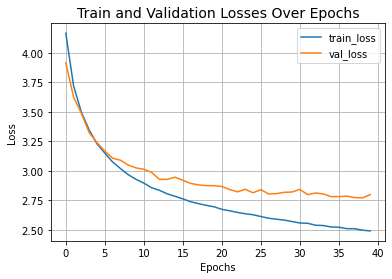

In [12]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

Let's display the final results of the training on CIFAR-100.

In [13]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 4s 8ms/step - loss: 2.7497 - accuracy: 0.4178 - top-5-accuracy: 0.7212
Test loss: 2.75
Test accuracy: 41.78%
Test top 5 accuracy: 72.12%


The Swin Transformer model we just trained has just 152K parameters, and it gets
us to ~75% test top-5 accuracy within just 40 epochs without any signs of overfitting
as well as seen in above graph. This means we can train this network for longer
(perhaps with a bit more regularization) and obtain even better performance.
This performance can further be improved by additional techniques like cosine
decay learning rate schedule, other data augmentation techniques. While experimenting,
I tried training the model for 150 epochs with a slightly higher dropout and greater
embedding dimensions which pushes the performance to ~72% test accuracy on CIFAR-100
as you can see in the screenshot.

![Results of training for longer](https://i.imgur.com/9vnQesZ.png)

The authors present a top-1 accuracy of 87.3% on ImageNet. The authors also present
a number of experiments to study how input sizes, optimizers etc. affect the final
performance of this model. The authors further present using this model for object detection,
semantic segmentation and instance segmentation as well and report competitive results
for these. You are strongly advised to also check out the
[original paper](https://arxiv.org/abs/2103.14030).

This example takes inspiration from the official
[PyTorch](https://github.com/microsoft/Swin-Transformer) and
[TensorFlow](https://github.com/VcampSoldiers/Swin-Transformer-Tensorflow) implementations.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.empty(1,512, 256, 64)
shifted_x = F.pad(x, [0, 0, 4, 3, 2, 1], "constant", 0)
print(shifted_x.size())

x = tf.zeros([1,512, 256, 64])
shifted_x = tf.pad(x, [[0, 0],[2, 1], [4, 3],[0, 0]], "constant", 0)
print(shifted_x.get_shape().as_list())

x = torch.randn(128, 32, 8)
m = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=1, groups=8)
y = m(x)
print(y.shape)
#y = m(x.permute(0, 2, 1))
#y.permute(0, 2, 1).shape #torch.Size([256, 237, 1024])

x = tf.random.normal((128, 32, 8))
m = tf.keras.layers.Conv1D(filters=32, kernel_size=1, groups=8, data_format='channels_first')
y = m(x)
print(y.shape) #TensorShape([256, 237, 1024])

torch.Size([1, 515, 263, 64])
[1, 515, 263, 64]
torch.Size([128, 32, 8])
(128, 32, 8)
